In [1]:
#!/usr/bin/env python
# coding: utf-8


import os
import time
from collections import namedtuple
from dataclasses import dataclass
import numpy as np
from PIL import Image
from PIL import ImageOps

import equinox as eqx
import jax
import jax.numpy as jnp
import jax.tree_util as jtu
import matplotlib.pyplot as plt
import numpy as np
import optax
import pandas as pd
import pyro
import pyro.contrib.examples.multi_mnist as multi_mnist
import seaborn as sns

from manim import *

import genjax
from genjax import Pytree, vi
from genjax.typing import Any, FloatArray, Int, IntArray, Tuple, typecheck

key = jax.random.PRNGKey(314159)
sns.set_theme(style="white")
label_fontsize = 70  # Set the desired font size here

smoke_test = "CI" in os.environ
assert pyro.__version__.startswith("1.8.6")


inpath = "./data/air/.data"
X_np, Y = multi_mnist.load(inpath)
X_np = X_np.astype(np.float32)
X_np /= 255.0
mnist = jnp.array(X_np)
true_counts = jnp.array([len(objs) for objs in Y])


# ## Defining the variational ingredients

# ### Utilities / learnable pieces


# Utilities for defining the model and the guide.


@dataclass
class Decoder(Pytree):
    dense_1: Any
    dense_2: Any

    def flatten(self):
        return (self.dense_1, self.dense_2), ()

    @classmethod
    def new(cls, key1, key2):
        dense_1 = eqx.nn.Linear(50, 200, key=key1)
        dense_2 = eqx.nn.Linear(200, 400, key=key2)
        return Decoder(dense_1, dense_2)

    def __call__(self, z_what):
        v = self.dense_1(z_what)
        v = jax.nn.leaky_relu(v)
        v = self.dense_2(v)
        return jax.nn.sigmoid(v)


# Create our decoder.
key, sub_key1, sub_key2 = jax.random.split(key, 3)
decoder = Decoder.new(sub_key1, sub_key2)

# Create our RNN for the guide.
key, sub_key = jax.random.split(key)
rnn = eqx.nn.LSTMCell(2554, 256, key=sub_key)


@dataclass
class Encoder(Pytree):
    dense_1: Any
    dense_2: Any

    def flatten(self):
        return (self.dense_1, self.dense_2), ()

    @classmethod
    def new(cls, key1, key2):
        dense_1 = eqx.nn.Linear(400, 200, key=key1)
        dense_2 = eqx.nn.Linear(200, 100, key=key2)
        return Encoder(dense_1, dense_2)

    def __call__(self, data):
        v = self.dense_1(data)
        v = jax.nn.leaky_relu(v)
        v = self.dense_2(v)
        return v[0:50], jax.nn.softplus(v[50:])


key, sub_key1, sub_key2 = jax.random.split(key, 3)
encoder = Encoder.new(sub_key1, sub_key2)


@dataclass
class Predict(Pytree):
    dense: Any

    def flatten(self):
        return (self.dense,), ()

    @classmethod
    def new(cls, key):
        dense = eqx.nn.Linear(256, 7, key=key)
        return Predict(dense)

    def __call__(self, h):
        a = self.dense(h)
        z_pres_p = jax.nn.sigmoid(a[0:1])
        z_where_loc = a[1:4]
        z_where_scale = jax.nn.softplus(a[4:])
        return z_pres_p, z_where_loc, z_where_scale


key, sub_key = jax.random.split(key)
predict = Predict.new(key)


#######
# STN #
#######

# modified from https://github.com/kevinzakka/spatial-transformer-network/blob/master/stn/transformer.py


def affine_grid_generator(height, width, theta):
    """
    This function returns a sampling grid, which when
    used with the bilinear sampler on the input feature
    map, will create an output feature map that is an
    affine transformation [1] of the input feature map.

    Input
    -----
    - height: desired height of grid/output. Used
      to downsample or upsample.

    - width: desired width of grid/output. Used
      to downsample or upsample.

    - theta: affine transform matrices of shape (num_batch, 2, 3).
      For each image in the batch, we have 6 theta parameters of
      the form (2x3) that define the affine transformation T.

    Returns
    -------
    - normalized grid (-1, 1) of shape (num_batch, 2, H, W).
      The 2nd dimension has 2 components: (x, y) which are the
      sampling points of the original image for each point in the
      target image.

    Note
    ----
    [1]: the affine transformation allows cropping, translation,
         and isotropic scaling.
    """
    num_batch = theta.shape[0]

    # create normalized 2D grid
    x = jnp.linspace(-1.0, 1.0, width)
    y = jnp.linspace(-1.0, 1.0, height)
    x_t, y_t = jnp.meshgrid(x, y)

    # flatten
    x_t_flat = jnp.reshape(x_t, [-1])
    y_t_flat = jnp.reshape(y_t, [-1])

    # reshape to [x_t, y_t , 1] - (homogeneous form)
    ones = jnp.ones_like(x_t_flat)
    sampling_grid = jnp.stack([x_t_flat, y_t_flat, ones])

    # repeat grid num_batch times
    sampling_grid = jnp.expand_dims(sampling_grid, axis=0)
    sampling_grid = jnp.tile(sampling_grid, [num_batch, 1, 1])

    # transform the sampling grid - batch multiply
    batch_grids = jnp.matmul(theta, sampling_grid)
    # batch grid has shape (num_batch, 2, H*W)

    # reshape to (num_batch, 2, H, W)
    batch_grids = jnp.reshape(batch_grids, [num_batch, 2, height, width])

    return batch_grids


def bilinear_sampler(img, x, y):
    """
    Performs bilinear sampling of the input images according to the
    normalized coordinates provided by the sampling grid. Note that
    the sampling is done identically for each channel of the input.

    To test if the function works properly, output image should be
    identical to input image when theta is initialized to identity
    transform.

    Input
    -----
    - img: batch of images in (B, H, W, C) layout.
    - grid: x, y which is the output of affine_grid_generator.

    Returns
    -------
    - out: interpolated images according to grids. Same size as grid.
    """
    H = jnp.shape(img)[1]
    W = jnp.shape(img)[2]
    max_y = H - 1
    max_x = W - 1
    zero = jnp.zeros([], dtype=int)

    # rescale x and y to [0, W-1/H-1]
    x = 0.5 * ((x + 1.0) * max_x - 1)
    y = 0.5 * ((y + 1.0) * max_y - 1)

    # grab 4 nearest corner points for each (x_i, y_i)
    x0 = jnp.floor(x).astype(int)
    x1 = x0 + 1
    y0 = jnp.floor(y).astype(int)
    y1 = y0 + 1

    # clip to range [0, H-1/W-1] to not violate img boundaries
    x0 = jnp.clip(x0, zero, max_x)
    x1 = jnp.clip(x1, zero, max_x)
    y0 = jnp.clip(y0, zero, max_y)
    y1 = jnp.clip(y1, zero, max_y)

    # get pixel value at corner coords
    Ia = get_pixel_value(img, x0, y0)
    Ib = get_pixel_value(img, x0, y1)
    Ic = get_pixel_value(img, x1, y0)
    Id = get_pixel_value(img, x1, y1)

    # recast as float for delta calculation
    x0 = x0.astype(float)
    x1 = x1.astype(float)
    y0 = y0.astype(float)
    y1 = y1.astype(float)

    # calculate deltas
    wa = (x1 - x) * (y1 - y)
    wb = (x1 - x) * (y - y0)
    wc = (x - x0) * (y1 - y)
    wd = (x - x0) * (y - y0)

    # add dimension for addition
    wa = jnp.expand_dims(wa, axis=3)
    wb = jnp.expand_dims(wb, axis=3)
    wc = jnp.expand_dims(wc, axis=3)
    wd = jnp.expand_dims(wd, axis=3)

    # compute output
    out = wa * Ia + wb * Ib + wc * Ic + wd * Id
    return out


def get_pixel_value(img, x, y):
    """
    Utility function to get pixel value for coordinate
    vectors x and y from a  4D tensor image.

    Input
    -----
    - img: tensor of shape (B, H, W, C)
    - x: flattened tensor of shape (B*H*W,)
    - y: flattened tensor of shape (B*H*W,)

    Returns
    -------
    - output: tensor of shape (B, H, W, C)
    """
    batch_size, height, width = jnp.shape(x)

    batch_idx = jnp.arange(0, batch_size)
    batch_idx = jnp.reshape(batch_idx, (batch_size, 1, 1))
    b = jnp.tile(batch_idx, (1, height, width))

    indices = jnp.stack([b, y, x], 3)

    return gather_nd(img, indices)


# from: https://github.com/google/jax/discussions/6119
def gather_nd_unbatched(params, indices):
    return params[tuple(jnp.moveaxis(indices, -1, 0))]


def gather_nd(params, indices, batch=False):
    if not batch:
        return gather_nd_unbatched(params, indices)
    else:
        return vmap(gather_nd_unbatched, (0, 0), 0)(params, indices)


def expand_z_where(z_where):
    # Takes 3-dimensional vectors, and massages them into 2x3 matrices with elements like so:
    # [s,x,y] -> [[s,0,x],
    #             [0,s,y]]
    n = 1
    expansion_indices = jnp.array([1, 0, 2, 0, 1, 3])
    z_where = jnp.expand_dims(z_where, axis=0)
    out = jnp.concatenate((jnp.broadcast_to(jnp.zeros([1, 1]), (n, 1)), z_where), 1)
    return jnp.reshape(out[:, expansion_indices], (n, 2, 3))


def object_to_image(z_where, obj):
    n = 1
    theta = expand_z_where(z_where)
    grid = affine_grid_generator(50, 50, theta)
    x_s = grid[:, 0, :, :]
    y_s = grid[:, 1, :, :]
    out = bilinear_sampler(jnp.reshape(obj, (n, 20, 20, 1)), x_s, y_s)
    return jnp.reshape(out, (50, 50))


def z_where_inv(z_where):
    # Take a batch of z_where vectors, and compute their "inverse".
    # That is, for each row compute:
    # [s,x,y] -> [1/s,-x/s,-y/s]
    # These are the parameters required to perform the inverse of the
    # spatial transform performed in the generative model.
    out = jnp.array([1, *(-z_where[1:])])
    out = out / z_where[0]
    return out


def image_to_object(z_where, image):
    n = 1
    theta_inv = expand_z_where(z_where_inv(z_where))
    grid = affine_grid_generator(20, 20, theta_inv)
    x_s = grid[:, 0, :, :]
    y_s = grid[:, 1, :, :]
    out = bilinear_sampler(jnp.reshape(image, (n, 50, 50, 1)), x_s, y_s)
    return jnp.reshape(out, (400,))


# ### Model


#########
# Model #
#########

# Fixed constants.
z_where_prior_loc = jnp.array([3.0, 0.0, 0.0])
z_where_prior_scale = jnp.array([0.2, 1.0, 1.0])
z_what_prior_loc = jnp.zeros(50, dtype=float)
z_what_prior_scale = jnp.ones(50, dtype=float)
z_pres_prior = [0.05, 0.05**2.3, 0.05 ** (5)]
eps = 1e-4


@genjax.gen
@typecheck
def step(
    t: Int,
    decoder: Decoder,
    prev_x: FloatArray,
    prev_z_pres: IntArray,
):
    z_pres = vi.flip_mvd(z_pres_prior[t]) @ f"z_pres_{t}"
    z_pres = jnp.array([z_pres.astype(int)])
    z_where = (
        vi.mv_normal_diag_reparam(z_where_prior_loc, z_where_prior_scale)
        @ f"z_where_{t}"
    )
    z_what = (
        vi.mv_normal_diag_reparam(z_what_prior_loc, z_what_prior_scale) @ f"z_what_{t}"
    )
    y_att = decoder(z_what)
    y = object_to_image(z_where, y_att)
    x = prev_x + (y * z_pres)
    return x, z_pres


# TODO: Make sure that this works, where t is a static int.
@genjax.gen
@typecheck
def model(decoder: Decoder):
    x = jnp.zeros((50, 50), dtype=float)
    z_pres = jnp.ones(1, dtype=int)
    for t in range(3):
        x, z_pres = step.inline(t, decoder, x, z_pres)
    vi.mv_normal_diag_reparam(x, 0.3 * jnp.ones_like(x)) @ "obs"
    return x


# #### Samples from the model


tr = jax.jit(model.simulate)(key, (decoder,))
tr.strip()


# ### Guide


#########
# Guide #
#########


@genjax.gen
@typecheck
def guide_step(
    t: Int,
    rnn: eqx.nn.LSTMCell,
    encoder: Encoder,
    predict: Predict,
    data,
    prev: Tuple,
):
    (prev_z_where, prev_z_what, prev_z_pres, prev_h, prev_c) = prev
    rnn_input = jnp.concatenate([data, prev_z_where, prev_z_what, prev_z_pres])
    h, c = rnn(rnn_input, (prev_h, prev_c))
    z_pres_p, z_where_loc, z_where_scale = predict(h)
    z_pres = (
        vi.flip_mvd((eps + (z_pres_p[0] * prev_z_pres[0])) / (1 + 1.01 * eps))
        @ f"z_pres_{t}"
    )
    z_pres = jnp.array([z_pres.astype(int)])
    z_where = vi.mv_normal_diag_reparam(z_where_loc, z_where_scale) @ f"z_where_{t}"
    x_att = image_to_object(z_where, data)
    z_what_loc, z_what_scale = encoder(x_att)
    z_what = vi.mv_normal_diag_reparam(z_what_loc, z_what_scale) @ f"z_what_{t}"
    return z_where, z_what, z_pres, h, c


@genjax.gen
@typecheck
def guide(
    data: genjax.ChoiceMap,
    rnn: eqx.nn.LSTMCell,
    encoder: Encoder,
    predict: Predict,
):
    h = jnp.zeros(256)
    c = jnp.zeros(256)
    z_pres = jnp.ones(1)
    z_where = jnp.zeros(3)
    z_what = jnp.zeros(50)
    img = data["obs"]
    img_arr = img.flatten()

    for t in range(3):
        (z_where, z_what, z_pres, h, c) = guide_step.inline(
            t, rnn, encoder, predict, img_arr, (z_where, z_what, z_pres, h, c)
        )


# #### Samples from the guide


data_chm = genjax.choice_map({"obs": jnp.ones((50, 50))})
tr = jax.jit(guide.simulate)(key, (data_chm, rnn, encoder, predict))
tr.strip()


# ## Training

# ### Make sure grads are working

# #### Define ELBO objective


data = genjax.choice_map({"obs": jnp.ones((50, 50))})
objective = vi.elbo(model, guide, data)
objective


# #### Go go grads


jitted = jax.jit(objective.value_and_grad_estimate)
loss, ((decoder_grads,), (_, rnn_grads, encoder_grads, predict_grads)) = jitted(
    key, ((decoder,), (data, rnn, encoder, predict))
)


loss


# ### Dataloader


def data_loader(
    data,
    batch_size,
    shuffle=True,
):
    N = len(data)
    data_idxs = np.arange(N)
    num_batch = int(np.ceil(N // batch_size))

    def init(key):
        return (
            num_batch,
            jax.random.permutation(key, data_idxs) if shuffle else data_idxs,
        )

    def get_batch(i=0, idxs=data_idxs):
        ret_idx = jax.lax.dynamic_slice_in_dim(idxs, i * batch_size, batch_size)
        return jax.lax.index_take(data, (ret_idx,), axes=(0,))

    return init, get_batch


##################
# Count Accuracy #
##################


def count_accuracy(data, true_counts, guide, batch_size=1000):
    global prng_key
    assert data.shape[0] == true_counts.shape[0], "Size mismatch."
    assert data.shape[0] % batch_size == 0, "Input size must be multiple of batch_size."

    def eval_guide(key, data, params):
        data_chmp = genjax.choice_map({"obs": data})
        return guide.simulate(key, (data_chmp, *params))

    batch_eval_guide = jax.jit(jax.vmap(eval_guide, in_axes=(0, 0, None)))

    @jax.jit
    def evaluate_count_accuracy(key, params):
        def evaluate_batch(counts, batch_id):
            data_batch = jax.lax.dynamic_slice_in_dim(
                data, batch_id * batch_size, batch_size
            )
            true_counts_batch = jax.lax.dynamic_slice_in_dim(
                true_counts, batch_id * batch_size, batch_size
            )
            genjax.choice_map({"obs": data_batch})
            # evaluate guide
            keys = jax.random.split(jax.random.fold_in(key, batch_id), batch_size)
            tr = batch_eval_guide(keys, data_batch, params)
            [tr[f"z_where_{i}"] for i in range(3)]
            z_pres = [tr[f"z_pres_{i}"] for i in range(3)]
            # compute stats
            inferred_counts = sum(z for z in z_pres)
            true_counts_m = jax.nn.one_hot(true_counts_batch, 3)
            inferred_counts_m = jax.nn.one_hot(inferred_counts, 4)
            counts += (true_counts_m.T @ inferred_counts_m).astype(int)
            error_ind = 1 - (true_counts_batch == inferred_counts).astype(int)
            # error_ix = error_ind.nonzero()[0]
            # error_latent = jnp.take(latents_to_tensor((z_where, z_pres)), error_ix, 0)
            return counts, error_ind

        counts = jnp.zeros((3, 4), dtype=int)
        counts, error_indices = jax.lax.scan(
            evaluate_batch, counts, jnp.arange(data.shape[0] // batch_size)
        )

        acc = jnp.sum(jnp.diag(counts)).astype(float) / data.shape[0]
        error_indices = jnp.concatenate(
            error_indices
        )  # .nonzero()[0]  # <- not JIT compilable
        return acc, counts, error_indices

    return evaluate_count_accuracy


# Combine z_pres and z_where (as returned by the model and guide) into
# a single tensor, with size:
# [batch_size, num_steps, z_where_size + z_pres_size]
def latents_to_tensor(z):
    return jnp.stack(
        [
            jnp.concatenate((z_where, z_pres.reshape(-1, 1)), 1)
            for z_where, z_pres in zip(*z)
        ]
    ).transpose(1, 0, 2)


##################
# Visualization  #
##################


z_obj = namedtuple("z", ["s", "x", "y", "pres"])


# Map a tensor of latents (as produced by latents_to_tensor) to a list
# of z_obj named tuples.
def tensor_to_objs(latents):
    return [[z_obj._make(step) for step in z] for z in latents]

/home/femtomc/.cache/pypoetry/virtualenvs/programmable-vi-pldi-2024--B04dNNz-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-06-22 12:45:20.601543: W external/xla/xla/service/gpu/nvptx_compiler.cc:679] The NVIDIA driver's CUDA version is 12.4 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [2]:
evaluate_accuracy = count_accuracy(mnist, true_counts, guide, batch_size=1000)

def train(key, n=2, num_epochs=10, batch_size=64, learning_rate=1.0e-3):
    def svi_update(model, guide, optimiser):
        def batch_updater(key, params, opt_state, data_batch):
            def grads(key, params, data):
                (decoder, rnn, encoder, predict) = params
                data = genjax.choice_map({"obs": data})
                objective = vi.iwae_elbo(model, guide, data, n)
                (
                    loss,
                    (
                        (decoder_grads,),
                        (_, rnn_grads, encoder_grads, predict_grads),
                    ),
                ) = objective.value_and_grad_estimate(
                    key, ((decoder,), (data, rnn, encoder, predict))
                )
                return loss, (decoder_grads, rnn_grads, encoder_grads, predict_grads)

            sub_keys = jax.random.split(key, len(data_batch))
            loss, (decoder_grads, rnn_grads, encoder_grads, predict_grads) = jax.vmap(
                grads, in_axes=(0, None, 0)
            )(sub_keys, params, data_batch)

            grads = jtu.tree_map(
                lambda v: -1.0 * jnp.mean(v, axis=0),
                (decoder_grads, rnn_grads, encoder_grads, predict_grads),
            )
            updates, opt_state = optimiser.update(grads, opt_state, params)
            params = optax.apply_updates(params, updates)
            loss = jnp.mean(loss)
            return params, opt_state, loss

        return batch_updater

    adam = optax.adam(learning_rate)
    svi_updater = svi_update(model, guide, adam)

    @jax.jit
    def epoch_train(opt_state, params, key, train_idx):
        def body_fn(carry, xs):
            idx, params, opt_state, loss = carry
            updater_key = jax.random.fold_in(key, idx)
            batch = train_fetch(idx, train_idx)
            params, opt_state, loss = svi_updater(updater_key, params, opt_state, batch)
            idx += 1
            return (idx, params, opt_state, loss), loss

        idx = 0
        (_, params, opt_state, _), losses = jax.lax.scan(
            body_fn, (idx, params, opt_state, 0.0), None, length=num_batch
        )
        return params, opt_state, losses

    # Train.
    params = (decoder, rnn, encoder, predict)
    opt_state = adam.init(params)
    params_list = [params]
    wall_clock_times = [0.0]
    
    acc_time = 0.0
    train_init, train_fetch = data_loader(jnp.array(mnist), batch_size)
    key, sub_key = jax.random.split(key)
    num_batch, train_idx = train_init(sub_key)

    # Warm up.
    _, _, loss = epoch_train(opt_state, params, key, train_idx)
    losses = [loss[0]]
    acc, counts, error_ix = evaluate_accuracy(sub_key, params[1:])
    accuracies = [acc]

    t0 = time.perf_counter()
    acc_time = 0.0
    for i in range(0, num_epochs + 1):
        key, sub_key = jax.random.split(key)
        num_batch, train_idx = train_init(sub_key)
        key, sub_key = jax.random.split(key)
        start = time.perf_counter() - t0
        params, opt_state, loss = epoch_train(opt_state, params, sub_key, train_idx)
        stop = time.perf_counter() - t0
        acc_time += stop - start
        acc, counts, error_ix = evaluate_accuracy(sub_key, params[1:])
        losses.append(jnp.mean(loss))
        wall_clock_times.append(acc_time)
        accuracies.append(acc)
        params_list.append(params)
        print(
            f"Epoch={i}, total_epoch_step_time={acc_time:.2f}, loss={jnp.mean(loss):.2f}"
        )
        print("accuracy={}, counts={}".format(acc, counts))

    return losses, accuracies, wall_clock_times, params_list

key = jax.random.PRNGKey(314159)
losses, accuracies, wall_clock_times, params_list = train(key, n=2, num_epochs=10)

Epoch=0, total_epoch_step_time=3.32, loss=466.66
accuracy=0.8279833197593689, counts=[[15981  3804   161     2]
 [  360 16238  3362    60]
 [   49  1691 17460   832]]
Epoch=1, total_epoch_step_time=6.77, loss=587.45
accuracy=0.9423666596412659, counts=[[19091   851     6     0]
 [   98 18713  1207     2]
 [    8  1159 18738   127]]
Epoch=2, total_epoch_step_time=10.28, loss=612.12
accuracy=0.9609333276748657, counts=[[19571   377     0     0]
 [   48 18833  1139     0]
 [    5   665 19252   110]]
Epoch=3, total_epoch_step_time=13.72, loss=622.46
accuracy=0.9731667041778564, counts=[[19731   217     0     0]
 [   27 19636   357     0]
 [    0   982 19023    27]]
Epoch=4, total_epoch_step_time=17.16, loss=627.80
accuracy=0.9762666821479797, counts=[[19784   164     0     0]
 [   16 19703   301     0]
 [    1   927 19089    15]]
Epoch=5, total_epoch_step_time=20.61, loss=631.36
accuracy=0.9787499904632568, counts=[[19827   121     0     0]
 [   12 19767   241     0]
 [    1   889 19131   

In [87]:
config.background_color = WHITE
config.disable_caching = True
config.pixel_height = 360
config.pixel_width = 360
config.frame_height = 32.0
config.frame_width = 50.0

def trunc(values, decs=0):
    return np.trunc(values*10**decs)/(10**decs)

def bounding_box(z_where, x_size):
    w = x_size / z_where.s
    h = x_size / z_where.s
    xtrans = -z_where.x / z_where.s * x_size / 2.0
    ytrans = -z_where.y / z_where.s * x_size / 2.0
    x = (x_size - w) / 2 + xtrans  # origin is top left
    y = (x_size - h) / 2 + ytrans
    return (x, y), w, h

def get_bbox(z, img_width):
    (x, y), w, h = bounding_box(z, img_width)
    w = 1.06 * w
    h = 1.06 * h
    return [
        (x, img_width - y),
        (x + w, img_width - y),
        (x + w, img_width - (y + h)),
        (x, img_width - (y + h)),
    ]

def draw_one(img, z, label, bounding_box=False):
    (img, z) = jtu.tree_map(lambda v: jnp.squeeze(v), (img, z))
    normalized_data = 255.0 - np.array((img / img.max() * 255).astype(np.uint8))

    axes = Axes(
        x_range=[0, 50, 1],
        y_range=[0, 50, 1],
        x_length=10,
        y_length=10,
        axis_config={"color": BLACK},
    )
    axes.set_opacity(0)  # Set the axes lines to fully transparent

    # Create rectangles based on data
    rgroup = VGroup()
    rect_width = 10 / 50
    rect_height = 10 / 50
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            grey_value = normalized_data[i][j]
            color = color_to_rgb(grey_value)
            rect = Rectangle(
                width=rect_width, height=rect_height,
                fill_color=color, fill_opacity=1, 
                stroke_color=BLACK, stroke_width=0.01
            )
            x = j + 1 / 2
            y = 50 - (i + 1 / 2)
            rect.move_to(axes.c2p(x, y, 0))
            rgroup.add(rect)

    bbgroup = VGroup()
    if bounding_box:
        z_where = z[0]
        colors = [RED, GREEN, BLUE]
        for k, z in enumerate(z_where):
            if z.pres > 0:
                rect = Polygon(
                    *[axes.c2p(*i) for i in get_bbox(z, img.shape[0])],
                    color=colors[k],
                )
                bbgroup.add(rect)

    srect = SurroundingRectangle(rgroup, color=BLACK, buff=0.2)  # `buff` is the padding
    label = Text(label, color=BLACK).next_to(srect, UP, buff=0.2)
    return VGroup(axes, label, 
                  srect, 
                  rgroup, 
                  bbgroup,
                 )
    
def visualize_model(model, guide):
    def reconstruct_digit(key, data, params):
        decoder, rnn, encoder, predict = params
        data_chmp = genjax.choice_map({"obs": data})
        key1, key2 = jax.random.split(key)
        tr = guide.simulate(key1, (data_chmp, rnn, encoder, predict))
        _, tr = model.importance(key2, tr, (decoder,))
        reconstruction = tr.get_retval()
        z_where = [tr[f"z_where_{i}"] for i in range(3)]
        z_pres = [tr[f"z_pres_{i}"] for i in range(3)]
        return reconstruction, (z_where, z_pres)

    reconstruct_digit = jax.jit(reconstruct_digit)

    def visualize(key, params, example_to_viz):
        recon, z = reconstruct_digit(key, example_to_viz, params)
        z = jtu.tree_map(lambda v: jnp.expand_dims(v, 0), z)
        z_where = tensor_to_objs(latents_to_tensor(z))
        orig = draw_one(example_to_viz.reshape(-1, 50, 50), z_where, "Original image")
        recon = draw_one(recon, z_where, "Reconstructed image", bounding_box=True)
        recon.next_to(orig, RIGHT)
        return VGroup(orig, recon)

    return visualize
    
def color_to_rgb(grey_scale):
    """ Convert a greyscale value to a RGB color. """
    intensity = grey_scale / 255
    return rgb_to_color([intensity]*3)

class TrainingAnimation(Scene):     
    def construct(self):
        loss_axes = Axes(
            x_range=[0, 11, 1],
            y_range=[-750, 650, 200],
            x_length=11,
            y_length=5,
            tips=False,
            axis_config={"color": BLACK, "include_numbers": True},
        )
        loss_title = Text("ELBO Estimate", color=BLACK).next_to(loss_axes, UP)
        acc_axes = Axes(
            x_range=[0, 11, 1],
            y_range=[0, 1, 0.3],
            x_length=11,
            y_length=5,
            tips=False,
            axis_config={
                "color": BLACK, 
                "include_numbers": True,
                "label_direction": DOWN,  # Direction for x labels
            }
        )
        acc_axes.next_to(loss_axes, DOWN, buff=1.0)
        acc_title = Text("Validation count accuracy", color=BLACK).next_to(acc_axes, UP)
        epoch_text = Text("Training epochs", color=BLACK).next_to(acc_axes, DOWN)
        axes_vgroup = VGroup(loss_axes, loss_title, acc_axes, acc_title, epoch_text).shift(10 * LEFT)
        self.add(axes_vgroup)
        x = acc_axes.get_x_axis()
        x.numbers.set_color(BLACK)
        y_loss = loss_axes.get_y_axis()
        y_loss.numbers.set_color(BLACK)
        y_acc = acc_axes.get_y_axis()
        y_acc.numbers.set_color(BLACK)
        previous_loss_dot = None
        previous_acc_dot = None
        for idx, (l, a, t, p) in enumerate(zip(losses, accuracies, wall_clock_times, params_list)):
            digits = self.visualize(key, l, a, t, p)
            digits.next_to(axes_vgroup, 5 * RIGHT)
            self.add(digits)
            acc_dot = Dot(acc_axes.c2p(idx, a), color=BLACK)
            self.add(acc_dot)
            loss_dot = Dot(loss_axes.c2p(idx, l), color=BLACK)
            self.add(loss_dot)
            if previous_loss_dot is not None:
                line = Line(previous_loss_dot.get_center(), loss_dot.get_center(), color=BLUE)
                self.add(line)
            if previous_acc_dot is not None:
                line = Line(previous_acc_dot.get_center(), acc_dot.get_center(), color=BLUE)
                self.add(line)
            previous_loss_dot = loss_dot
            previous_acc_dot = acc_dot
            self.wait(0.7)
            self.remove(digits)
        
    def visualize(self, key, loss, accuracy, wall_clock_time, params):
        visualize_examples = mnist[59999:]
        visualize = visualize_model(model, guide)
        digits_vgroup = visualize(key, params, visualize_examples)
        wall_clock_time = Text(f"Total training wall clock time: {trunc(wall_clock_time, 2)} (s)", color=BLACK).next_to(digits_vgroup, 2 * DOWN)
        return VGroup(wall_clock_time, digits_vgroup)
        
%manim -qh TrainingAnimation

Manim Community v0.18.1

[06/22/24 13:17:48] INFO     Caching disabled.                                                 ]8;id=230340;file:///home/femtomc/.cache/pypoetry/virtualenvs/programmable-vi-pldi-2024--B04dNNz-py3.10/lib/python3.10/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=202670;file:///home/femtomc/.cache/pypoetry/virtualenvs/programmable-vi-pldi-2024--B04dNNz-py3.10/lib/python3.10/site-packages/manim/renderer/cairo_renderer.py#78\78]8;;\

[06/22/24 13:17:49] INFO     Animation 0 : Partial movie file written in                   ]8;id=985314;file:///home/femtomc/.cache/pypoetry/virtualenvs/programmable-vi-pldi-2024--B04dNNz-py3.10/lib/python3.10/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=418274;file:///home/femtomc/.cache/pypoetry/virtualenvs/programmable-vi-pldi-2024--B04dNNz-py3.10/lib/python3.10/site-packages/manim/scene/scene_file_writer.py#527\527]8;;\
                             '/home/femtomc/Research/programmable-vi-pldi-2024/animations/                         
                             media/videos/animations/1080p60/partial_movie_files/TrainingA                         
                             nimation/uncached_00000.mp4'                                                          

[06/22/24 13:17:52] INFO     Caching disabled.                                                 ]8;id=740977;file:///home/femtomc/.cache/pypoetry/virtualenvs/programmable-vi-pldi-2024--B04dNNz-py3.10/lib/python3.10/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=952940;file:///home/femtomc/.cache/pypoetry/virtualenvs/programmable-vi-pldi-2024--B04dNNz-py3.10/lib/python3.10/site-packages/manim/renderer/cairo_renderer.py#78\78]8;;\

                    INFO     Animation 1 : Partial movie file written in                   ]8;id=539327;file:///home/femtomc/.cache/pypoetry/virtualenvs/programmable-vi-pldi-2024--B04dNNz-py3.10/lib/python3.10/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=979844;file:///home/femtomc/.cache/pypoetry/virtualenvs/programmable-vi-pldi-2024--B04dNNz-py3.10/lib/python3.10/site-packages/manim/scene/scene_file_writer.py#527\527]8;;\
                             '/home/femtomc/Research/programmable-vi-pldi-2024/animations/                         
                             media/videos/animations/1080p60/partial_movie_files/TrainingA                         
                             nimation/uncached_00001.mp4'                                                          

[06/22/24 13:17:56] INFO     Caching disabled.                                                 ]8;id=605110;file:///home/femtomc/.cache/pypoetry/virtualenvs/programmable-vi-pldi-2024--B04dNNz-py3.10/lib/python3.10/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=80381;file:///home/femtomc/.cache/pypoetry/virtualenvs/programmable-vi-pldi-2024--B04dNNz-py3.10/lib/python3.10/site-packages/manim/renderer/cairo_renderer.py#78\78]8;;\

                    INFO     Animation 2 : Partial movie file written in                   ]8;id=600170;file:///home/femtomc/.cache/pypoetry/virtualenvs/programmable-vi-pldi-2024--B04dNNz-py3.10/lib/python3.10/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=394233;file:///home/femtomc/.cache/pypoetry/virtualenvs/programmable-vi-pldi-2024--B04dNNz-py3.10/lib/python3.10/site-packages/manim/scene/scene_file_writer.py#527\527]8;;\
                             '/home/femtomc/Research/programmable-vi-pldi-2024/animations/                         
                             media/videos/animations/1080p60/partial_movie_files/TrainingA                         
                             nimation/uncached_00002.mp4'                                                          

[06/22/24 13:17:59] INFO     Caching disabled.                                                 ]8;id=21223;file:///home/femtomc/.cache/pypoetry/virtualenvs/programmable-vi-pldi-2024--B04dNNz-py3.10/lib/python3.10/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=495236;file:///home/femtomc/.cache/pypoetry/virtualenvs/programmable-vi-pldi-2024--B04dNNz-py3.10/lib/python3.10/site-packages/manim/renderer/cairo_renderer.py#78\78]8;;\

[06/22/24 13:18:00] INFO     Animation 3 : Partial movie file written in                   ]8;id=607541;file:///home/femtomc/.cache/pypoetry/virtualenvs/programmable-vi-pldi-2024--B04dNNz-py3.10/lib/python3.10/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=941163;file:///home/femtomc/.cache/pypoetry/virtualenvs/programmable-vi-pldi-2024--B04dNNz-py3.10/lib/python3.10/site-packages/manim/scene/scene_file_writer.py#527\527]8;;\
                             '/home/femtomc/Research/programmable-vi-pldi-2024/animations/                         
                             media/videos/animations/1080p60/partial_movie_files/TrainingA                         
                             nimation/uncached_00003.mp4'                                                          

[06/22/24 13:18:03] INFO     Caching disabled.                                                 ]8;id=777159;file:///home/femtomc/.cache/pypoetry/virtualenvs/programmable-vi-pldi-2024--B04dNNz-py3.10/lib/python3.10/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=915453;file:///home/femtomc/.cache/pypoetry/virtualenvs/programmable-vi-pldi-2024--B04dNNz-py3.10/lib/python3.10/site-packages/manim/renderer/cairo_renderer.py#78\78]8;;\

[06/22/24 13:18:04] INFO     Animation 4 : Partial movie file written in                   ]8;id=68559;file:///home/femtomc/.cache/pypoetry/virtualenvs/programmable-vi-pldi-2024--B04dNNz-py3.10/lib/python3.10/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=681854;file:///home/femtomc/.cache/pypoetry/virtualenvs/programmable-vi-pldi-2024--B04dNNz-py3.10/lib/python3.10/site-packages/manim/scene/scene_file_writer.py#527\527]8;;\
                             '/home/femtomc/Research/programmable-vi-pldi-2024/animations/                         
                             media/videos/animations/1080p60/partial_movie_files/TrainingA                         
                             nimation/uncached_00004.mp4'                                                          

[06/22/24 13:18:06] INFO     Caching disabled.                                                 ]8;id=731107;file:///home/femtomc/.cache/pypoetry/virtualenvs/programmable-vi-pldi-2024--B04dNNz-py3.10/lib/python3.10/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=857150;file:///home/femtomc/.cache/pypoetry/virtualenvs/programmable-vi-pldi-2024--B04dNNz-py3.10/lib/python3.10/site-packages/manim/renderer/cairo_renderer.py#78\78]8;;\

[06/22/24 13:18:07] INFO     Animation 5 : Partial movie file written in                   ]8;id=974152;file:///home/femtomc/.cache/pypoetry/virtualenvs/programmable-vi-pldi-2024--B04dNNz-py3.10/lib/python3.10/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=191371;file:///home/femtomc/.cache/pypoetry/virtualenvs/programmable-vi-pldi-2024--B04dNNz-py3.10/lib/python3.10/site-packages/manim/scene/scene_file_writer.py#527\527]8;;\
                             '/home/femtomc/Research/programmable-vi-pldi-2024/animations/                         
                             media/videos/animations/1080p60/partial_movie_files/TrainingA                         
                             nimation/uncached_00005.mp4'                                                          

[06/22/24 13:18:10] INFO     Caching disabled.                                                 ]8;id=982029;file:///home/femtomc/.cache/pypoetry/virtualenvs/programmable-vi-pldi-2024--B04dNNz-py3.10/lib/python3.10/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=697756;file:///home/femtomc/.cache/pypoetry/virtualenvs/programmable-vi-pldi-2024--B04dNNz-py3.10/lib/python3.10/site-packages/manim/renderer/cairo_renderer.py#78\78]8;;\

                    INFO     Animation 6 : Partial movie file written in                   ]8;id=209640;file:///home/femtomc/.cache/pypoetry/virtualenvs/programmable-vi-pldi-2024--B04dNNz-py3.10/lib/python3.10/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=170936;file:///home/femtomc/.cache/pypoetry/virtualenvs/programmable-vi-pldi-2024--B04dNNz-py3.10/lib/python3.10/site-packages/manim/scene/scene_file_writer.py#527\527]8;;\
                             '/home/femtomc/Research/programmable-vi-pldi-2024/animations/                         
                             media/videos/animations/1080p60/partial_movie_files/TrainingA                         
                             nimation/uncached_00006.mp4'                                                          

[06/22/24 13:18:14] INFO     Caching disabled.                                                 ]8;id=66743;file:///home/femtomc/.cache/pypoetry/virtualenvs/programmable-vi-pldi-2024--B04dNNz-py3.10/lib/python3.10/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=172732;file:///home/femtomc/.cache/pypoetry/virtualenvs/programmable-vi-pldi-2024--B04dNNz-py3.10/lib/python3.10/site-packages/manim/renderer/cairo_renderer.py#78\78]8;;\

                    INFO     Animation 7 : Partial movie file written in                   ]8;id=98577;file:///home/femtomc/.cache/pypoetry/virtualenvs/programmable-vi-pldi-2024--B04dNNz-py3.10/lib/python3.10/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=61740;file:///home/femtomc/.cache/pypoetry/virtualenvs/programmable-vi-pldi-2024--B04dNNz-py3.10/lib/python3.10/site-packages/manim/scene/scene_file_writer.py#527\527]8;;\
                             '/home/femtomc/Research/programmable-vi-pldi-2024/animations/                         
                             media/videos/animations/1080p60/partial_movie_files/TrainingA                         
                             nimation/uncached_00007.mp4'                                                          

[06/22/24 13:18:17] INFO     Caching disabled.                                                 ]8;id=55164;file:///home/femtomc/.cache/pypoetry/virtualenvs/programmable-vi-pldi-2024--B04dNNz-py3.10/lib/python3.10/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=48693;file:///home/femtomc/.cache/pypoetry/virtualenvs/programmable-vi-pldi-2024--B04dNNz-py3.10/lib/python3.10/site-packages/manim/renderer/cairo_renderer.py#78\78]8;;\

[06/22/24 13:18:18] INFO     Animation 8 : Partial movie file written in                   ]8;id=492247;file:///home/femtomc/.cache/pypoetry/virtualenvs/programmable-vi-pldi-2024--B04dNNz-py3.10/lib/python3.10/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=80365;file:///home/femtomc/.cache/pypoetry/virtualenvs/programmable-vi-pldi-2024--B04dNNz-py3.10/lib/python3.10/site-packages/manim/scene/scene_file_writer.py#527\527]8;;\
                             '/home/femtomc/Research/programmable-vi-pldi-2024/animations/                         
                             media/videos/animations/1080p60/partial_movie_files/TrainingA                         
                             nimation/uncached_00008.mp4'                                                          

[06/22/24 13:18:21] INFO     Caching disabled.                                                 ]8;id=575845;file:///home/femtomc/.cache/pypoetry/virtualenvs/programmable-vi-pldi-2024--B04dNNz-py3.10/lib/python3.10/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=49789;file:///home/femtomc/.cache/pypoetry/virtualenvs/programmable-vi-pldi-2024--B04dNNz-py3.10/lib/python3.10/site-packages/manim/renderer/cairo_renderer.py#78\78]8;;\

[06/22/24 13:18:22] INFO     Animation 9 : Partial movie file written in                   ]8;id=9225;file:///home/femtomc/.cache/pypoetry/virtualenvs/programmable-vi-pldi-2024--B04dNNz-py3.10/lib/python3.10/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=473939;file:///home/femtomc/.cache/pypoetry/virtualenvs/programmable-vi-pldi-2024--B04dNNz-py3.10/lib/python3.10/site-packages/manim/scene/scene_file_writer.py#527\527]8;;\
                             '/home/femtomc/Research/programmable-vi-pldi-2024/animations/                         
                             media/videos/animations/1080p60/partial_movie_files/TrainingA                         
                             nimation/uncached_00009.mp4'                                                          

[06/22/24 13:18:24] INFO     Caching disabled.                                                 ]8;id=336427;file:///home/femtomc/.cache/pypoetry/virtualenvs/programmable-vi-pldi-2024--B04dNNz-py3.10/lib/python3.10/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=562389;file:///home/femtomc/.cache/pypoetry/virtualenvs/programmable-vi-pldi-2024--B04dNNz-py3.10/lib/python3.10/site-packages/manim/renderer/cairo_renderer.py#78\78]8;;\

[06/22/24 13:18:25] INFO     Animation 10 : Partial movie file written in                  ]8;id=609225;file:///home/femtomc/.cache/pypoetry/virtualenvs/programmable-vi-pldi-2024--B04dNNz-py3.10/lib/python3.10/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=496654;file:///home/femtomc/.cache/pypoetry/virtualenvs/programmable-vi-pldi-2024--B04dNNz-py3.10/lib/python3.10/site-packages/manim/scene/scene_file_writer.py#527\527]8;;\
                             '/home/femtomc/Research/programmable-vi-pldi-2024/animations/                         
                             media/videos/animations/1080p60/partial_movie_files/TrainingA                         
                             nimation/uncached_00010.mp4'                                                          

[06/22/24 13:18:28] INFO     Caching disabled.                                                 ]8;id=620782;file:///home/femtomc/.cache/pypoetry/virtualenvs/programmable-vi-pldi-2024--B04dNNz-py3.10/lib/python3.10/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=622468;file:///home/femtomc/.cache/pypoetry/virtualenvs/programmable-vi-pldi-2024--B04dNNz-py3.10/lib/python3.10/site-packages/manim/renderer/cairo_renderer.py#78\78]8;;\

[06/22/24 13:18:29] INFO     Animation 11 : Partial movie file written in                  ]8;id=150865;file:///home/femtomc/.cache/pypoetry/virtualenvs/programmable-vi-pldi-2024--B04dNNz-py3.10/lib/python3.10/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=334248;file:///home/femtomc/.cache/pypoetry/virtualenvs/programmable-vi-pldi-2024--B04dNNz-py3.10/lib/python3.10/site-packages/manim/scene/scene_file_writer.py#527\527]8;;\
                             '/home/femtomc/Research/programmable-vi-pldi-2024/animations/                         
                             media/videos/animations/1080p60/partial_movie_files/TrainingA                         
                             nimation/uncached_00011.mp4'                                                          

                    INFO     Combining to Movie file.                                      ]8;id=207612;file:///home/femtomc/.cache/pypoetry/virtualenvs/programmable-vi-pldi-2024--B04dNNz-py3.10/lib/python3.10/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=822147;file:///home/femtomc/.cache/pypoetry/virtualenvs/programmable-vi-pldi-2024--B04dNNz-py3.10/lib/python3.10/site-packages/manim/scene/scene_file_writer.py#617\617]8;;\

                    INFO                                                                   ]8;id=64684;file:///home/femtomc/.cache/pypoetry/virtualenvs/programmable-vi-pldi-2024--B04dNNz-py3.10/lib/python3.10/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=219787;file:///home/femtomc/.cache/pypoetry/virtualenvs/programmable-vi-pldi-2024--B04dNNz-py3.10/lib/python3.10/site-packages/manim/scene/scene_file_writer.py#737\737]8;;\
                             File ready at                                                                         
                             '/home/femtomc/Research/programmable-vi-pldi-2024/animations/                         
                             media/videos/animations/1080p60/TrainingAnimation.mp4'                                
                                                                                                                   

                    INFO     Rendered TrainingAnimation                                                ]8;id=309844;file:///home/femtomc/.cache/pypoetry/virtualenvs/programmable-vi-pldi-2024--B04dNNz-py3.10/lib/python3.10/site-packages/manim/scene/scene.py\scene.py]8;;\:]8;id=713236;file:///home/femtomc/.cache/pypoetry/virtualenvs/programmable-vi-pldi-2024--B04dNNz-py3.10/lib/python3.10/site-packages/manim/scene/scene.py#247\247]8;;\
                             Played 12 animations                                                                  

(array([    5,     8,     9, ..., 59985, 59986, 59999]),)


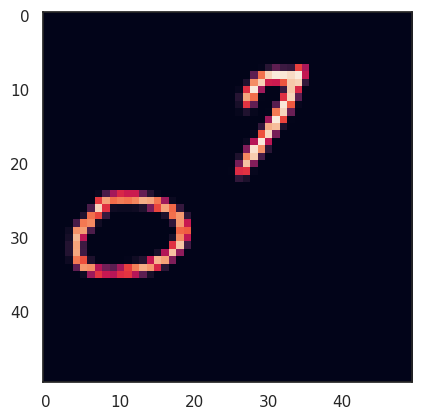

In [85]:
print(np.where(true_counts == 2))
img = visualize_examples = mnist[59999]
plt.imshow(img)